# Лабораторная работа №2. Перенос знаний

*Выполнил*: Подцепко Игорь Сергеевич, M33351

In [3]:
import torch
import torch.nn as nn

from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

In [4]:
class Config:
    DEVICE_NAME = "cuda" if torch.cuda.is_available() else "cpu"
    ROOT = "./data"
    BATCH_SIZE = 50
    EPOCHS_COUNT = 6
    BASE_TESTING_FREQUENCY = 10_000
    TESTING_FREQUENCY = BASE_TESTING_FREQUENCY / BATCH_SIZE

In [3]:
device = torch.device(Config.DEVICE_NAME)

Создаем простую структуру свёрточной сети:

In [4]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super(ConvolutionalNetwork, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),  # 32 x 28 x 28
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 32 x 14 x 14
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),  # 64 x 14 x 14
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 64 x 7 x 7
        )
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(7 * 7 * 64, 1000)
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.reshape(x.size(0), -1)  # 64 x 7 x 7 -> 3136
        x = self.drop_out(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [5]:
%%capture --no-stdout

from torchsummaryX import summary

print(summary(ConvolutionalNetwork(), torch.ones(1, 1, 28, 28)))

                        Kernel Shape     Output Shape   Params Mult-Adds
Layer                                                                   
0_layer1.Conv2d_0      [1, 32, 5, 5]  [1, 32, 28, 28]    832.0    627.2k
1_layer1.ReLU_1                    -  [1, 32, 28, 28]        -         -
2_layer1.MaxPool2d_2               -  [1, 32, 14, 14]        -         -
3_layer2.Conv2d_0     [32, 64, 5, 5]  [1, 64, 14, 14]  51.264k  10.0352M
4_layer2.ReLU_1                    -  [1, 64, 14, 14]        -         -
5_layer2.MaxPool2d_2               -    [1, 64, 7, 7]        -         -
6_drop_out                         -        [1, 3136]        -         -
7_fc1                   [3136, 1000]        [1, 1000]   3.137M    3.136M
8_fc2                     [1000, 10]          [1, 10]   10.01k     10.0k
----------------------------------------------------------------------------
                         Totals
Total params          3.199106M
Trainable params      3.199106M
Non-trainable params    

Определим вспомогательные функции для визуализации результатов и обучения моделей:

In [6]:
import os

import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib.gridspec as gs

import numpy as np


def draw_plots(
    title: str, x_label: str, y_label: str, x, y, rolling_average: int = 1
) -> None:
    pl.title(title)
    pl.xlabel(x_label)
    pl.ylabel(y_label)
    pl.plot(x, y, color="#DDDDDD" if rolling_average > 1 else "#DC2F02")
    if rolling_average > 1:
        pl.plot(
            x[: -rolling_average + 1 :],
            np.convolve(y, np.ones(rolling_average), "valid") / rolling_average,
            color="#DC2F02",
        )


def show_plots(
    train_loss: list[float], train_accuracy: list[float], test_accuracy: list[float]
) -> None:
    grid_spec = gs.GridSpec(2, 2)
    pl.figure()

    pl.figure(figsize=(15, 12))

    pl.subplot(grid_spec[0, :])
    draw_plots(
        title="Learning Curve",
        x_label="The number of batches on which the model is trained",
        y_label="Accuracy, %",
        x=np.arange(len(test_accuracy)) * Config.TESTING_FREQUENCY,
        y=test_accuracy,
    )
    pl.subplot(grid_spec[1, 0])
    draw_plots(
        title="Train Accuracy",
        x_label="The number of batches on which the model is trained",
        y_label="Accuracy, %",
        x=np.arange(len(train_accuracy)),
        y=train_accuracy,
        rolling_average=15,
    )
    pl.subplot(grid_spec[1, 1])
    draw_plots(
        title="Train Loss",
        x_label="The number of batches on which the model is trained",
        y_label="Loss",
        x=np.arange(len(train_loss)),
        y=train_loss,
        rolling_average=15,
    )
    pl.show()


def format_i_from(i: int, count: int):
    return f"[{str(i).rjust(len(str(count)))}/{count}]"


def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    test_loader: DataLoader,
    epochs: int = Config.EPOCHS_COUNT,
    file: str = None,
    show: bool = True,
) -> list[float] | tuple[list[float], list[float], list[float]]:
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    criterion = nn.CrossEntropyLoss()
    train_loss = []
    train_accuracy = []
    test_accuracy = []
    for epoch in range(epochs):
        # Train part
        model.train()
        for batch, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            train_loss.append(loss.data.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total = labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            train_accuracy.append(100.0 * correct / total)

            if (batch + 1) % Config.TESTING_FREQUENCY == 0:
                test_accuracy.append(test_model(model, test_loader))
                print(
                    f"{format_i_from(epoch + 1, epochs)} {format_i_from(batch + 1, len(train_loader))} Accuracy: {test_accuracy[-1]}%"
                )

    if file is not None:
        if not os.path.exists("models"):
            os.makedirs("models")
        torch.save(model.state_dict(), f"models/{file}")

    if show:
        show_plots(train_loss, train_accuracy, test_accuracy)
        return test_accuracy

    return train_loss, train_accuracy, test_accuracy


def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    model.train()
    return 100.0 * correct / total

Для первого эксперимента нам понадобится набор данных MNIST, определим общую функцию для загрузки датасета:

In [7]:
def load_dataset(dataset, transform=transforms.ToTensor()):
    train_dataset = dataset(
        root=Config.ROOT, train=True, transform=transform, download=True
    )
    test_dataset = dataset(root=Config.ROOT, train=False, transform=transform)

    return (
        DataLoader(dataset=train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True),
        DataLoader(dataset=test_dataset, batch_size=Config.BATCH_SIZE, shuffle=False),
    )

In [8]:
%%capture
mnist_train_loader, mnist_test_loader = load_dataset(datasets.MNIST)

## Эксперимент 1. Обучение сети на MNIST

[1/6] [ 200/1200] Accuracy: 91.47%
[1/6] [ 400/1200] Accuracy: 94.72%
[1/6] [ 600/1200] Accuracy: 95.73%
[1/6] [ 800/1200] Accuracy: 96.35%
[1/6] [1000/1200] Accuracy: 97.25%
[1/6] [1200/1200] Accuracy: 97.19%
[2/6] [ 200/1200] Accuracy: 97.37%
[2/6] [ 400/1200] Accuracy: 97.79%
[2/6] [ 600/1200] Accuracy: 97.98%
[2/6] [ 800/1200] Accuracy: 98.16%
[2/6] [1000/1200] Accuracy: 98.05%
[2/6] [1200/1200] Accuracy: 98.12%
[3/6] [ 200/1200] Accuracy: 98.28%
[3/6] [ 400/1200] Accuracy: 98.31%
[3/6] [ 600/1200] Accuracy: 98.43%
[3/6] [ 800/1200] Accuracy: 98.52%
[3/6] [1000/1200] Accuracy: 98.69%
[3/6] [1200/1200] Accuracy: 98.43%
[4/6] [ 200/1200] Accuracy: 98.75%
[4/6] [ 400/1200] Accuracy: 98.56%
[4/6] [ 600/1200] Accuracy: 98.72%
[4/6] [ 800/1200] Accuracy: 98.74%
[4/6] [1000/1200] Accuracy: 98.67%
[4/6] [1200/1200] Accuracy: 98.82%
[5/6] [ 200/1200] Accuracy: 98.68%
[5/6] [ 400/1200] Accuracy: 98.66%
[5/6] [ 600/1200] Accuracy: 98.84%
[5/6] [ 800/1200] Accuracy: 98.8%
[5/6] [1000/1200] Acc

<Figure size 640x480 with 0 Axes>

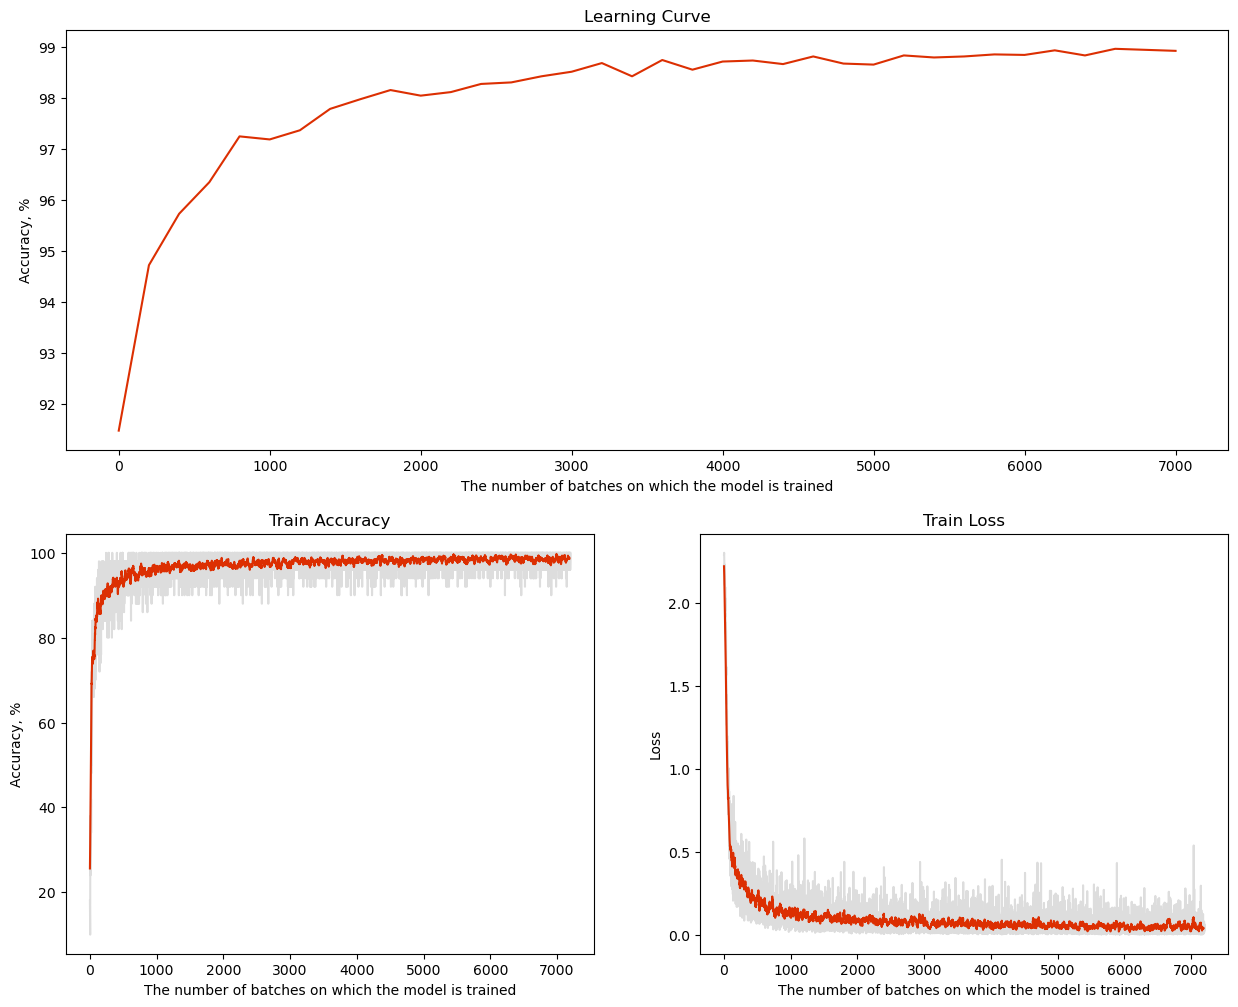

In [9]:
mnist_model = ConvolutionalNetwork()
train_model(
    model=mnist_model,
    train_loader=mnist_train_loader,
    test_loader=mnist_test_loader,
    file="mnist_model.pt",
)

## Эксперимент 2. Обучение сети на Fashion-MNIST

In [10]:
%%capture
fashion_mnist_train_loader, fashion_mnist_test_loader = load_dataset(datasets.FashionMNIST)

[1/6] [ 200/1200] Accuracy: 73.24%
[1/6] [ 400/1200] Accuracy: 79.83%
[1/6] [ 600/1200] Accuracy: 79.72%
[1/6] [ 800/1200] Accuracy: 83.03%
[1/6] [1000/1200] Accuracy: 83.82%
[1/6] [1200/1200] Accuracy: 83.86%
[2/6] [ 200/1200] Accuracy: 85.27%
[2/6] [ 400/1200] Accuracy: 84.81%
[2/6] [ 600/1200] Accuracy: 86.19%
[2/6] [ 800/1200] Accuracy: 86.16%
[2/6] [1000/1200] Accuracy: 86.7%
[2/6] [1200/1200] Accuracy: 86.11%
[3/6] [ 200/1200] Accuracy: 86.82%
[3/6] [ 400/1200] Accuracy: 86.7%
[3/6] [ 600/1200] Accuracy: 87.51%
[3/6] [ 800/1200] Accuracy: 87.68%
[3/6] [1000/1200] Accuracy: 87.95%
[3/6] [1200/1200] Accuracy: 87.77%
[4/6] [ 200/1200] Accuracy: 88.43%
[4/6] [ 400/1200] Accuracy: 87.58%
[4/6] [ 600/1200] Accuracy: 88.72%
[4/6] [ 800/1200] Accuracy: 88.25%
[4/6] [1000/1200] Accuracy: 88.72%
[4/6] [1200/1200] Accuracy: 88.59%
[5/6] [ 200/1200] Accuracy: 88.42%
[5/6] [ 400/1200] Accuracy: 88.74%
[5/6] [ 600/1200] Accuracy: 88.12%
[5/6] [ 800/1200] Accuracy: 88.96%
[5/6] [1000/1200] Accu

<Figure size 640x480 with 0 Axes>

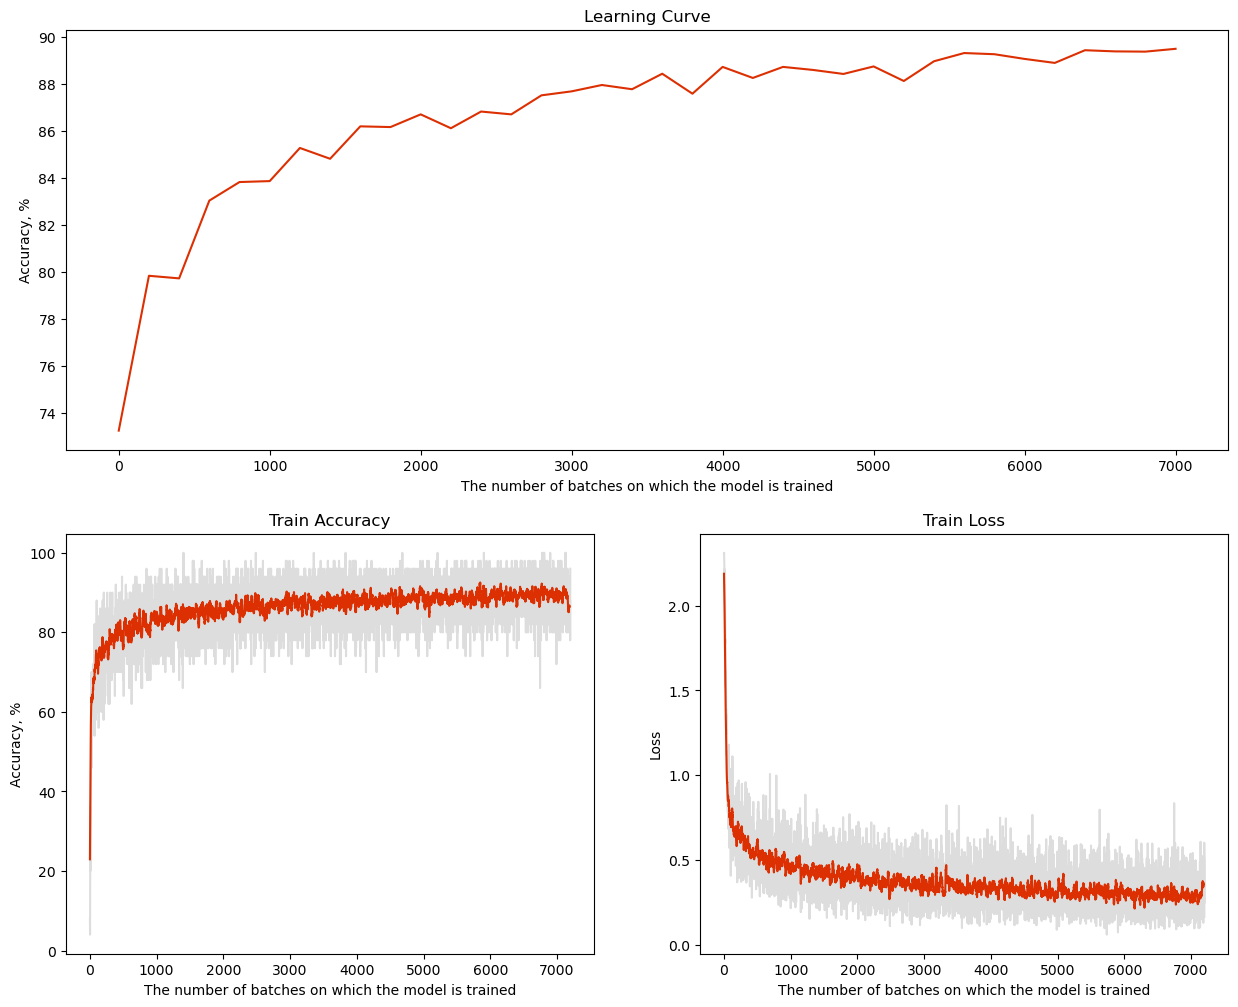

In [11]:
fashion_mnist_model = ConvolutionalNetwork()
basic_model_learning_curve = train_model(
    model=fashion_mnist_model,
    train_loader=fashion_mnist_train_loader,
    test_loader=fashion_mnist_test_loader,
)

## Эксперимент 3. Обучение на Fashion-MNIST модели, уже обученной на MNIST

[1/6] [ 200/1200] Accuracy: 77.7%
[1/6] [ 400/1200] Accuracy: 81.64%
[1/6] [ 600/1200] Accuracy: 83.35%
[1/6] [ 800/1200] Accuracy: 84.73%
[1/6] [1000/1200] Accuracy: 85.39%
[1/6] [1200/1200] Accuracy: 86.38%
[2/6] [ 200/1200] Accuracy: 86.58%
[2/6] [ 400/1200] Accuracy: 86.76%
[2/6] [ 600/1200] Accuracy: 86.98%
[2/6] [ 800/1200] Accuracy: 87.41%
[2/6] [1000/1200] Accuracy: 86.61%
[2/6] [1200/1200] Accuracy: 88.23%
[3/6] [ 200/1200] Accuracy: 88.04%
[3/6] [ 400/1200] Accuracy: 88.38%
[3/6] [ 600/1200] Accuracy: 88.53%
[3/6] [ 800/1200] Accuracy: 88.71%
[3/6] [1000/1200] Accuracy: 88.89%
[3/6] [1200/1200] Accuracy: 88.83%
[4/6] [ 200/1200] Accuracy: 88.84%
[4/6] [ 400/1200] Accuracy: 89.11%
[4/6] [ 600/1200] Accuracy: 89.01%
[4/6] [ 800/1200] Accuracy: 88.41%
[4/6] [1000/1200] Accuracy: 89.36%
[4/6] [1200/1200] Accuracy: 88.92%
[5/6] [ 200/1200] Accuracy: 89.19%
[5/6] [ 400/1200] Accuracy: 89.34%
[5/6] [ 600/1200] Accuracy: 89.48%
[5/6] [ 800/1200] Accuracy: 89.5%
[5/6] [1000/1200] Accu

<Figure size 640x480 with 0 Axes>

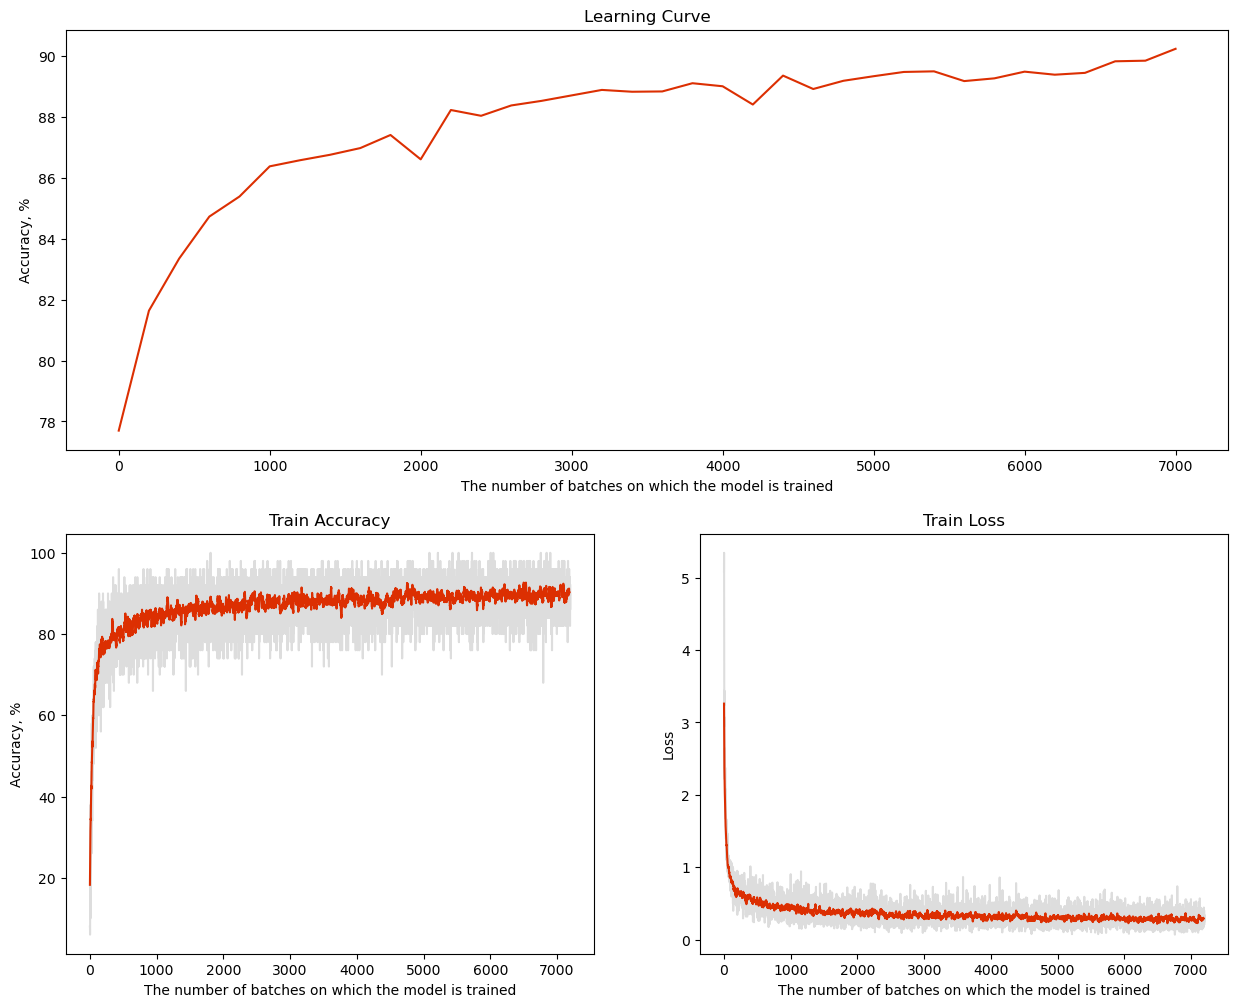

In [12]:
pretrained_model = ConvolutionalNetwork()
pretrained_model.load_state_dict(torch.load("models/mnist_model.pt"))

pretrained_model_learning_curve = train_model(
    model=pretrained_model,
    train_loader=fashion_mnist_train_loader,
    test_loader=fashion_mnist_test_loader,
)

## Эксперимент 4. Обучение на Fashion-MNIST предобученной на MNIST модели с заморозкой свёрточных слоёв

[1/6] [ 200/1200] Accuracy: 76.08%
[1/6] [ 400/1200] Accuracy: 80.35%
[1/6] [ 600/1200] Accuracy: 82.25%
[1/6] [ 800/1200] Accuracy: 83.63%
[1/6] [1000/1200] Accuracy: 84.47%
[1/6] [1200/1200] Accuracy: 85.33%
[2/6] [ 200/1200] Accuracy: 85.73%
[2/6] [ 400/1200] Accuracy: 85.93%
[2/6] [ 600/1200] Accuracy: 86.27%
[2/6] [ 800/1200] Accuracy: 86.57%
[2/6] [1000/1200] Accuracy: 86.61%
[2/6] [1200/1200] Accuracy: 86.81%
[3/6] [ 200/1200] Accuracy: 87.2%
[3/6] [ 400/1200] Accuracy: 86.94%
[3/6] [ 600/1200] Accuracy: 87.43%
[3/6] [ 800/1200] Accuracy: 87.35%
[3/6] [1000/1200] Accuracy: 87.43%
[3/6] [1200/1200] Accuracy: 87.04%
[4/6] [ 200/1200] Accuracy: 87.56%
[4/6] [ 400/1200] Accuracy: 87.93%
[4/6] [ 600/1200] Accuracy: 87.96%
[4/6] [ 800/1200] Accuracy: 87.96%
[4/6] [1000/1200] Accuracy: 88.07%
[4/6] [1200/1200] Accuracy: 87.72%
[5/6] [ 200/1200] Accuracy: 88.14%
[5/6] [ 400/1200] Accuracy: 88.31%
[5/6] [ 600/1200] Accuracy: 87.82%
[5/6] [ 800/1200] Accuracy: 88.01%
[5/6] [1000/1200] Acc

<Figure size 640x480 with 0 Axes>

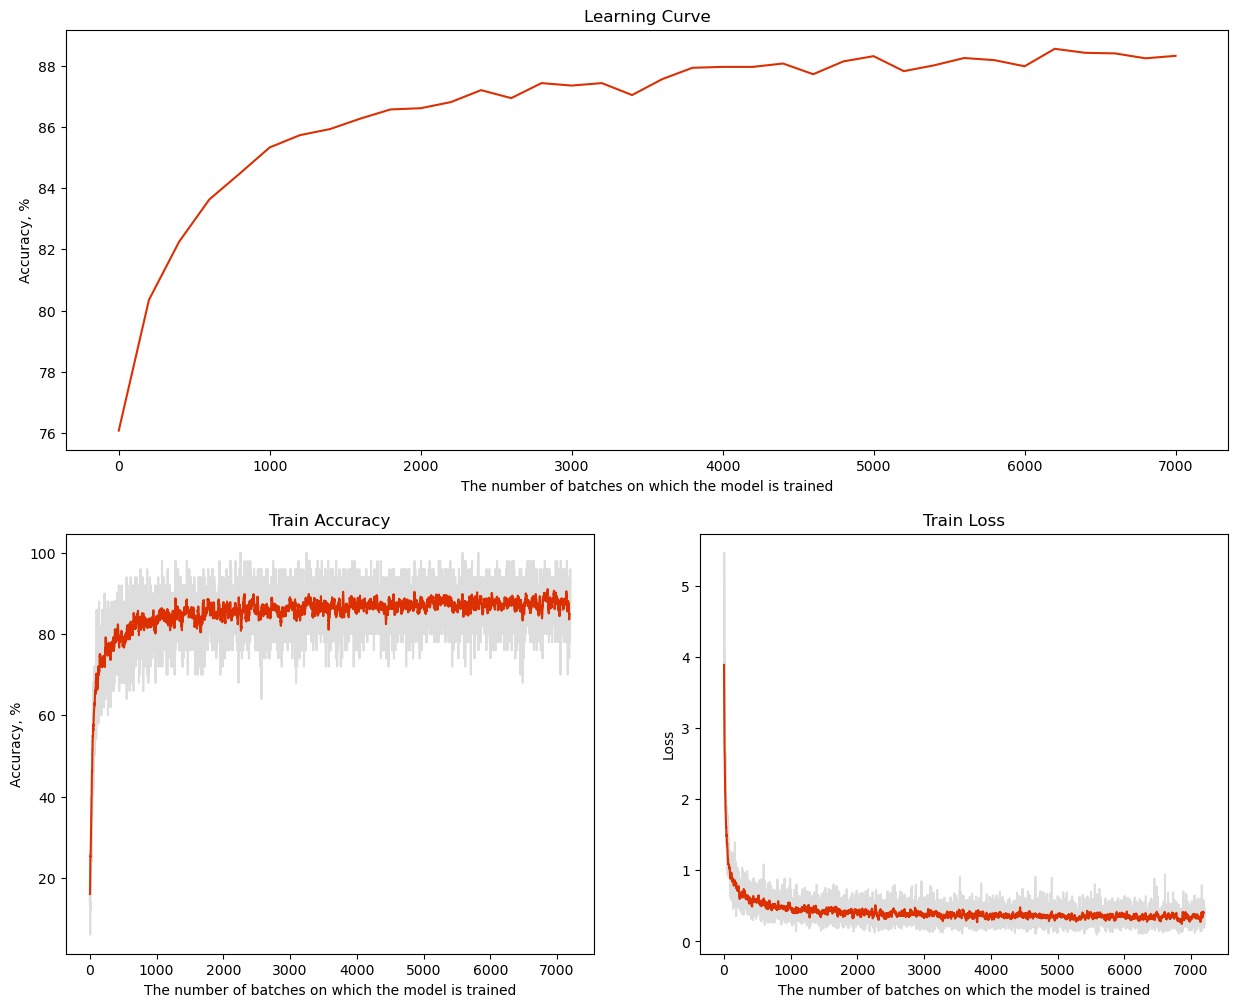

In [13]:
frozen_model = ConvolutionalNetwork()
frozen_model.load_state_dict(torch.load("models/mnist_model.pt"))

# Freeze part of layers
for name, parameter in frozen_model.named_parameters():
    if "layer" in name:
        parameter.requires_grad = False

frozen_model_learning_curve = train_model(
    model=frozen_model,
    train_loader=fashion_mnist_train_loader,
    test_loader=fashion_mnist_test_loader,
)

## Эксперимент 4. Обучение на Fashion-MNIST предобученной на MNIST модели с заморозкой и дальнейшей разморозкой свёрточных слоёв

[1/3] [ 200/1200] Accuracy: 76.06%
[1/3] [ 400/1200] Accuracy: 80.43%
[1/3] [ 600/1200] Accuracy: 82.55%
[1/3] [ 800/1200] Accuracy: 84.0%
[1/3] [1000/1200] Accuracy: 84.26%
[1/3] [1200/1200] Accuracy: 85.01%
[2/3] [ 200/1200] Accuracy: 85.9%
[2/3] [ 400/1200] Accuracy: 85.69%
[2/3] [ 600/1200] Accuracy: 86.55%
[2/3] [ 800/1200] Accuracy: 86.07%
[2/3] [1000/1200] Accuracy: 86.77%
[2/3] [1200/1200] Accuracy: 86.61%
[3/3] [ 200/1200] Accuracy: 86.86%
[3/3] [ 400/1200] Accuracy: 87.0%
[3/3] [ 600/1200] Accuracy: 87.07%
[3/3] [ 800/1200] Accuracy: 87.43%
[3/3] [1000/1200] Accuracy: 87.78%
[3/3] [1200/1200] Accuracy: 87.36%
[1/3] [ 200/1200] Accuracy: 87.72%
[1/3] [ 400/1200] Accuracy: 87.69%
[1/3] [ 600/1200] Accuracy: 88.02%
[1/3] [ 800/1200] Accuracy: 87.95%
[1/3] [1000/1200] Accuracy: 88.27%
[1/3] [1200/1200] Accuracy: 88.38%
[2/3] [ 200/1200] Accuracy: 88.08%
[2/3] [ 400/1200] Accuracy: 88.78%
[2/3] [ 600/1200] Accuracy: 88.42%
[2/3] [ 800/1200] Accuracy: 88.66%
[2/3] [1000/1200] Accur

<Figure size 640x480 with 0 Axes>

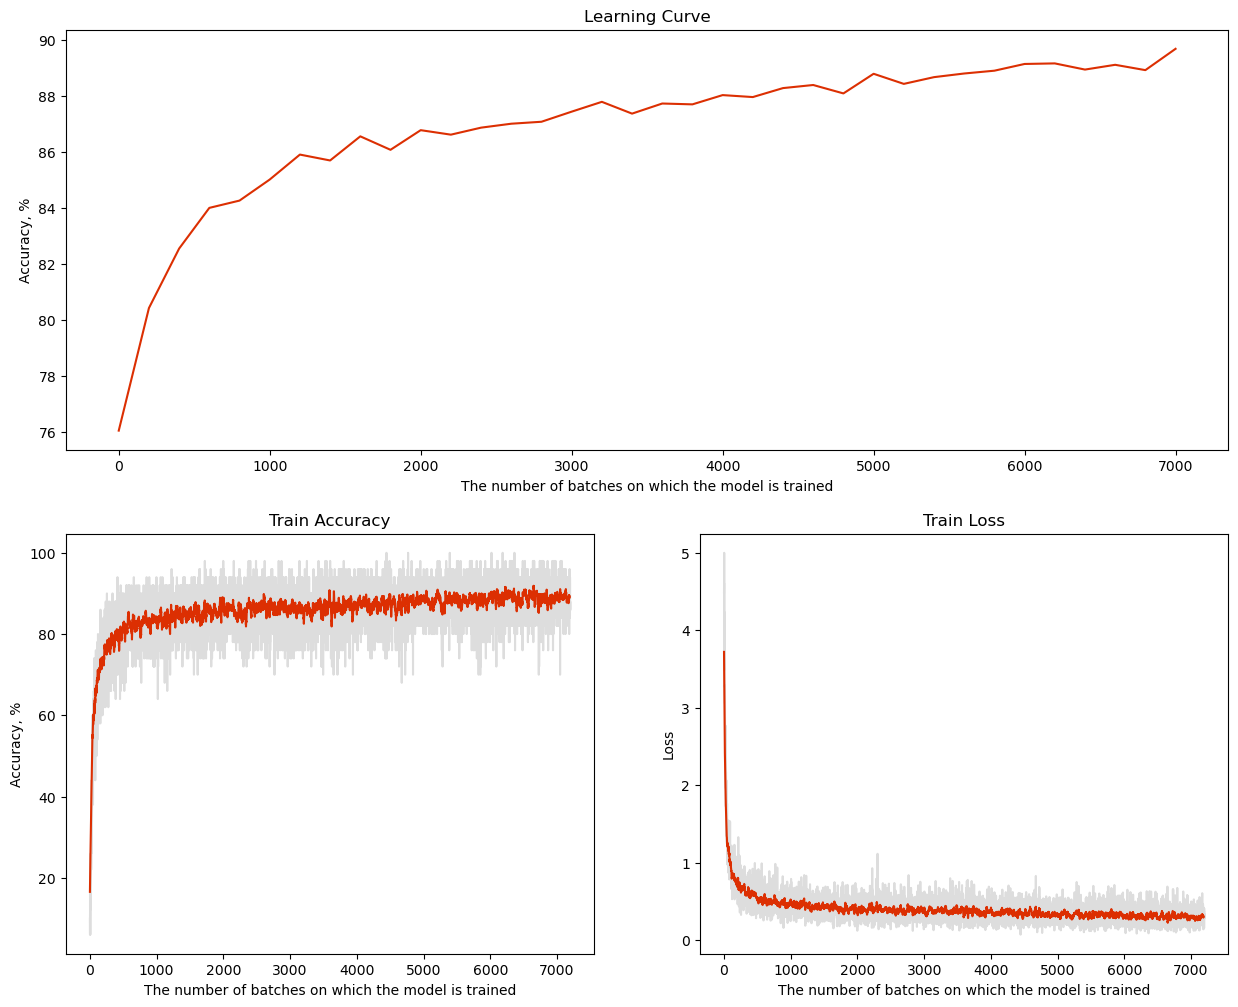

In [14]:
temporary_frozen_model = ConvolutionalNetwork()
temporary_frozen_model.load_state_dict(torch.load("models/mnist_model.pt"))

# Freeze part of layers
for name, parameter in temporary_frozen_model.named_parameters():
    if "layer" in name:
        parameter.requires_grad = False

epochs_before_defrosting = Config.EPOCHS_COUNT // 2

(
    train_lost_when_frosted,
    train_accuracy_when_frosted,
    learning_curve_when_frosted,
) = train_model(
    model=temporary_frozen_model,
    train_loader=fashion_mnist_train_loader,
    test_loader=fashion_mnist_test_loader,
    epochs=epochs_before_defrosting,
    show=False,
)

# Unfreeze parameters
for name, parameter in temporary_frozen_model.named_parameters():
    if "layer" in name:
        parameter.requires_grad = True

(
    train_lost_when_defrosted,
    train_accuracy_when_defrosted,
    learning_curve_when_defrosted,
) = train_model(
    model=temporary_frozen_model,
    train_loader=fashion_mnist_train_loader,
    test_loader=fashion_mnist_test_loader,
    epochs=Config.EPOCHS_COUNT - epochs_before_defrosting,
    show=False,
)

show_plots(
    train_lost_when_frosted + train_lost_when_defrosted,
    train_accuracy_when_frosted + train_accuracy_when_defrosted,
    learning_curve_when_frosted + learning_curve_when_defrosted,
)

## Сравнение результатов

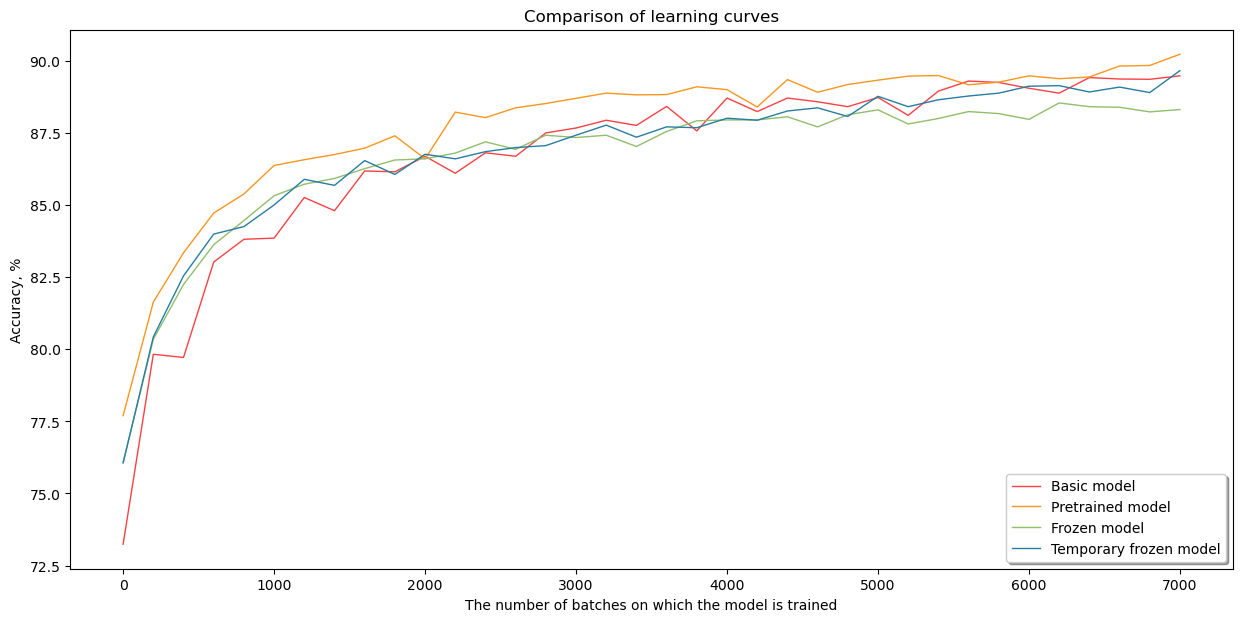

In [15]:
fig, ax = plt.subplots()

fig.set_figwidth(15)
fig.set_figheight(7)

numbers_of_batches = (
    np.arange(len(basic_model_learning_curve)) * Config.TESTING_FREQUENCY
)
ax.plot(
    numbers_of_batches,
    basic_model_learning_curve,
    color="#f94144",
    label="Basic model",
    linewidth=1,
)
ax.plot(
    numbers_of_batches,
    pretrained_model_learning_curve,
    color="#f8961e",
    label="Pretrained model",
    linewidth=1,
)
ax.plot(
    numbers_of_batches,
    frozen_model_learning_curve,
    color="#90be6d",
    label="Frozen model",
    linewidth=1,
)
ax.plot(
    numbers_of_batches,
    learning_curve_when_frosted + learning_curve_when_defrosted,
    color="#277da1",
    label="Temporary frozen model",
    linewidth=1,
)

ax.legend(loc="lower right", shadow=True)
ax.set_xlabel("The number of batches on which the model is trained")
ax.set_ylabel("Accuracy, %")
ax.set_title("Comparison of learning curves")

plt.show()